In [1]:
from pyspark.sql import SparkSession
import os

# Tạo thư mục tạm nếu chưa có
temp_dir = "D:/spark_temp"
os.makedirs(temp_dir, exist_ok=True)

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Heart Attack KMeans Clustering") \
    .config("spark.local.dir", temp_dir) \
    .getOrCreate()


In [2]:
df = spark.read.csv("D:/data/heart_attack_china.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

# Loại bỏ cột không cần thiết
target_col = "Heart_Attack"
drop_cols = ["Patient_ID", target_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

# Phân loại cột
categorical_cols = [c for c, t in df.dtypes if t == 'string' and c in feature_cols]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")


root
 |-- Patient_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Smoking_Status: string (nullable = true)
 |-- Hypertension: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Obesity: string (nullable = true)
 |-- Cholesterol_Level: string (nullable = true)
 |-- Air_Pollution_Exposure: string (nullable = true)
 |-- Physical_Activity: string (nullable = true)
 |-- Diet_Score: string (nullable = true)
 |-- Stress_Level: string (nullable = true)
 |-- Alcohol_Consumption: string (nullable = true)
 |-- Family_History_CVD: string (nullable = true)
 |-- Healthcare_Access: string (nullable = true)
 |-- Rural_or_Urban: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Hospital_Availability: string (nullable = true)
 |-- TCM_Use: string (nullable = true)
 |-- Employment_Status: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Inco

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline

# Index & OneHotEncoder cho cột phân loại
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="skip") for c in categorical_cols]
encoders = [OneHotEncoder(inputCols=[c+"_idx" for c in categorical_cols],
                          outputCols=[c+"_vec" for c in categorical_cols])]

# Assemble toàn bộ features
assembler_inputs = [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Index cho vector đặc trưng
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)

# Pipeline xử lý đặc trưng
stages = indexers + encoders + [assembler, featureIndexer]
pipeline = Pipeline(stages=stages)

# Biến đổi dữ liệu
pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df).select("indexedFeatures")

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def find_optimal_k(data, feature_col="indexedFeatures", k_min=2, k_max=10, runs=3):
    sil_scores = []
    k_values = list(range(k_min, k_max + 1))
    evaluator = ClusteringEvaluator(featuresCol=feature_col, metricName="silhouette", distanceMeasure="squaredEuclidean")

    for k in k_values:
        run_scores = []
        for _ in range(runs):
            kmeans = KMeans(featuresCol=feature_col, k=k, seed=np.random.randint(10000))
            model = kmeans.fit(data)
            preds = model.transform(data)
            score = evaluator.evaluate(preds)
            run_scores.append(score)
        sil_scores.append(np.mean(run_scores))

    # Vẽ biểu đồ Silhouette
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, sil_scores, marker='o', color='red')
    plt.xlabel("Số cụm")
    plt.ylabel("Chỉ số Silhouette")
    plt.title("Chỉ số Silhouette theo số cụm")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    best_k = k_values[np.argmax(sil_scores)]
    print(f"Số cụm tốt nhất: {best_k} theo Chỉ số Silhouette: {max(sil_scores):.4f}")
    return best_k


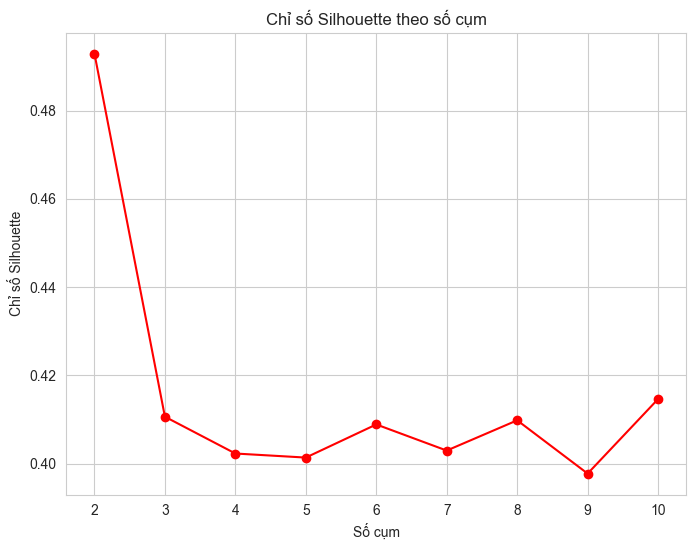

Số cụm tốt nhất: 2 theo Chỉ số Silhouette: 0.4929
+----------+------------------+------------------+-----------+
|prediction|Avg_CVD_Risk_Score|Avg_Blood_Pressure|Num_Records|
+----------+------------------+------------------+-----------+
|0         |77.0130107014065  |141.28702192993467|119517     |
|1         |32.001795422091206|141.1789743546919 |119749     |
+----------+------------------+------------------+-----------+



In [13]:

best_k = find_optimal_k(data, k_min=2, k_max=10, runs=3)
from pyspark.sql.functions import avg, count
# Huấn luyện mô hình với số cụm tốt nhất
kmeans = KMeans(featuresCol="indexedFeatures", k=best_k, seed=42)
model = kmeans.fit(data)

# Gán cụm vào dữ liệu đầy đủ
full_data = pipeline_model.transform(df)
predictions = model.transform(full_data)

# Phân tích cụm theo CVD_Risk_Score và Blood_Pressure
analyzed = predictions.select("prediction", "CVD_Risk_Score", "Blood_Pressure")
cluster_summary = analyzed.groupBy("prediction") \
    .agg(
        avg("CVD_Risk_Score").alias("Avg_CVD_Risk_Score"),
        avg("Blood_Pressure").alias("Avg_Blood_Pressure"),
        count("*").alias("Num_Records")
    ) \
    .orderBy("prediction")

# Hiển thị kết quả
cluster_summary.show(truncate=False)


In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="indexedFeatures", k=best_k, seed=42)
model = kmeans.fit(data)


In [15]:
result = model.transform(data)
result.select("indexedFeatures", "prediction").show(10, truncate=False)

# Hiển thị tâm cụm
print("Cluster centers:")
for center in model.clusterCenters():
    print(center)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|indexedFeatures                                                                                                                                                  |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|(46,[1,2,3,5,11,13,15,16,19,21,25,35,37,40,42,43,44,45],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.0,137.0,78.0])                           |0         |
|(46,[0,3,4,7,12,15,17,21,28,31,33,35,38,41,42,43,44,45],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.0,142.0,49.0])                           |1         |
|(46,[0,2,3,4,7,11,13,15,16,17,19,21,30,33,35,37,39,41,42,43,44,45],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

In [ ]:
spark.stop()
